In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import calendar
import functools
import os
import time

In [2]:
df = pd.read_csv("./data/sspsbpniv.csv")
df['Settlement Date'] = pd.to_datetime(df['Settlement Date'], dayfirst=True)
df = df[df['Settlement Period'] < 49]
df['Month'] = df['Settlement Date'].dt.month
df['Year'] = df['Settlement Date'].dt.year
df['Day'] = df['Settlement Date'].dt.day
df['Period'] = df['Settlement Period']
df = df.set_index(['Year', 'Month', 'Day', 'Settlement Period'])

<p>A simple method to determine when to sell/buy based on the settlement period is to take the median of the mean of the system sell price (SSP) grouped by settlement period. <br>When the current SSP is higher than the median - we sell<br>When it is lower - we buy<p>



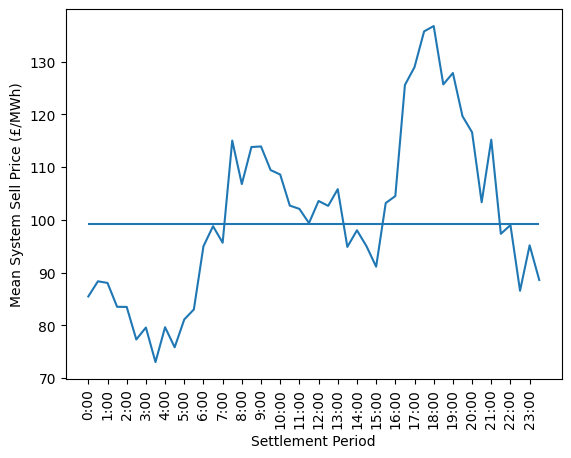

In [43]:
ssp_mean = df[['System Sell Price(£/MWh)']].groupby('Settlement Period').mean()
ssp_mean_median = ssp_mean.median()
plt.plot(ssp_mean)
plt.hlines(ssp_mean_median, 1, 48)

plt.xticks(range(1, 49, 2), [f"{x}:00" for x in range(24)], rotation=90)
plt.xlabel('Settlement Period')
plt.ylabel('Mean System Sell Price (£/MWh)')
plt.show()


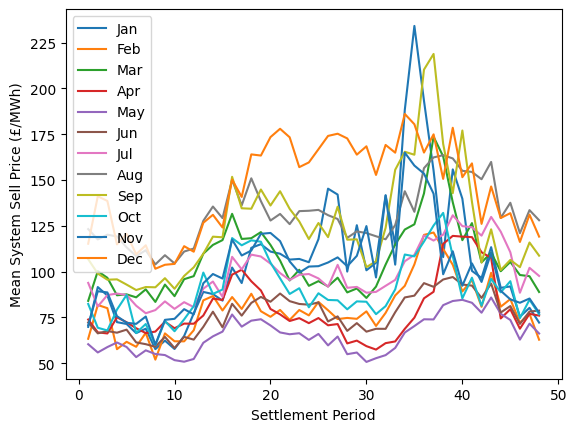

In [4]:
for i in range(1,13):
    df_plt = df.xs(i, level='Month') # \
    df_plt = df_plt[['System Sell Price(£/MWh)']]
    df_plt = df_plt.groupby('Settlement Period').mean(True)
    plt.plot(df_plt, label=calendar.month_abbr[i])

plt.xlabel('Settlement Period')
plt.ylabel('Mean System Sell Price (£/MWh)')
plt.legend()
plt.show()



In [5]:
c_rate = 0.1
c_eff = 0.80
decay_per_h = 0.01
cap_MWh = 10
c_rate_MWh = cap_MWh * c_rate

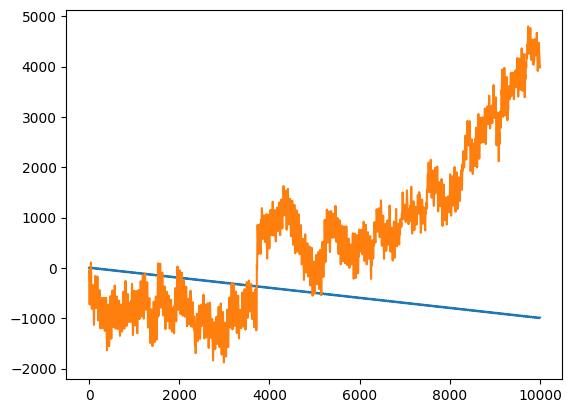

In [6]:
is_high_ssp = (ssp_mean > ssp_mean.median()).to_numpy()

class simple_state:
    def __init__(self) -> None:
        self.money = 0
        self.charge = 0

max_count = 10000
ch = []
mon = []

count = 0
charging = True
st = simple_state()
for i, row in df.iterrows():
    charging = not is_high_ssp[i[3] - 1]
    ssp = row['System Sell Price(£/MWh)']
    if(charging & (st.charge < 1000)):
        st.charge += c_rate_MWh * c_eff
        st.money -= ssp * c_rate_MWh
    elif(not charging & (st.charge > 0)):
        st.charge -= c_rate_MWh
        st.money += ssp * c_rate_MWh * c_eff
    ch.append(st.charge)
    mon.append(st.money)
    
    count += 1
    if(count == max_count):
        break

plt.plot(range(max_count), ch, mon)
plt.show()

<h1>Depth First Search</h1>
<p>Define State Class</p>

In [7]:
@functools.total_ordering
class dfs_state(simple_state):
    MAX_CHARGE = 1000
    CHARGE_RATE = 100
    EFF = 0.75
    DECAY = 0.01
    def __init__(self, initial_charge = 0, initial_money = 0):
        self.charge = initial_charge
        self.money = initial_money
        self.path = []
    
    def next(self, instruction, cur_price):
        # charge decays with each step
        new = dfs_state()
        charge = self.charge * (1 - self.DECAY)
        
        # we initialise differently depending on the instruction
        #BUY
        if(instruction == 'BUY'):
            new.charge = min(charge + self.CHARGE_RATE, self.MAX_CHARGE)
            new.money = self.money - (cur_price * (1 / self.EFF) * (new.charge - charge))
        #SELL
        elif(instruction == 'SELL'):
            new.charge = max(charge - self.CHARGE_RATE, 0)
            new.money = self.money + (cur_price * self.EFF * (charge - new.charge))
        #HOLD
        elif(instruction == 'HOLD'):
            new.charge  = charge
            new.money = self.money
        else:
            raise ValueError(instruction)
        
        new.path = [instruction]
        return new
    
    ## Simple estimate of 'value'
    ## Intended to avoid over-valuing discharging everything at max_depth
    ## Used when we reach max depth
    def finalise_value(self, cur_price):
        self.money = self.money + self.charge * cur_price * self.EFF
    
    def append(self, other):
        self.money = other.money
        self.path = self.path + other.path
        # self.path.append(other.path)
        
    def __eq__(self, __o: object) -> bool:
        return self.money == __o.money
    def __lt__(self, __o: object) -> bool:
        return self.money < __o.money
        
        
        

<p>Define recursive function</p>

In [11]:
def recurse(prices, depth, max_depth, state : dfs_state, step = 1):
    if(depth >= max_depth or depth >= prices.size ):
        state.finalise_value(prices[depth])
        return
    price = prices[depth]
    buy_st = state.next('BUY', price)
    recurse(prices, depth+step, max_depth, buy_st)

    sell_st = state.next('SELL', price)
    recurse(prices, depth+step, max_depth, sell_st)
    
    hold_st = state.next('HOLD', price)
    recurse(prices, depth+step, max_depth, hold_st)
    
    state.append(max(buy_st, sell_st, hold_st))

<p>Control</p>

In [25]:
def control(max_depth, step):
    mean_prices = df[['System Sell Price(£/MWh)']].groupby('Settlement Period').mean()['System Sell Price(£/MWh)'].to_numpy()
    state = dfs_state(500, 1000)
    recurse(mean_prices, 0, max_depth, state, step)
    df_control = pd.DataFrame(state.path)
    # df_control['Mean price'] = mean_prices[0:(max_depth*step) + 1:step]
    length = df_control.size
    print(length)
    df_control.index = [x for x in range(1, (df_control.size * step) + 1, step)]
    return df_control
control(47, 4)

KeyboardInterrupt: 

<p>Collate Test Data</p>

In [ ]:
def generate_samples(df : pd.DataFrame, sample_size : int, max_depth):
    step = 1
    samples = df.sample(sample_size)
    test_values = {}
    for ind in samples.index:
        max_ind = df.index[df.index.get_loc(ind) + (max_depth * step)]
        test_values[ind] = df.loc[ind:max_ind:step, lambda df:['Period', 'System Sell Price(£/MWh)']]
    return test_values

: 

<p>Perform Search</p>

In [ ]:
def search(df, sample_size, max_depth):
    test_values = generate_samples(df, sample_size, max_depth)
    results = {key:{'BUY':0, 'SELL':0, 'HOLD':0} for key in range(1, 49)}
    for k, v in test_values.items():
        prices = v['System Sell Price(£/MWh)'].to_numpy()
        initial_state = dfs_state(500, 1000)
        recurse(prices, 0, max_depth, initial_state)
        for p, q in zip(v['Period'].to_numpy(), initial_state.path):
            results[p][q] += 1
    df_results = pd.DataFrame.from_dict(results)
    return df_results

: 

In [ ]:
def save_results(df_res):
    if(os.path.exists('./data/dfs_results.csv')):
        df_old = pd.read_csv('./data/dfs_results.csv', index_col=0)
        df_old.columns = pd.to_numeric(df_old.columns)
        df_res = df_res.add(df_old, fill_value=0)
    df_res.to_csv('./data/dfs_results.csv', mode='w', na_rep='0')

: 

In [ ]:
MAX_DEPTH = 12
start = time.perf_counter()
while ((time.perf_counter() - start) < 360):
    df_results = search(df, 12, MAX_DEPTH)
    save_results(df_results)

: 

In [ ]:
df_t = df_results.transpose()
df_t['sum'] = df_t.sum(axis=1)
df_t['BUY frac'] = df_t['BUY'] / df_t['sum']
df_t['SELL frac'] = df_t['SELL'] / df_t['sum']
df_t['HOLD frac'] = df_t['HOLD'] / df_t['sum']

plt.stackplot(df_t.index, df_t['SELL frac'], 
              df_t['HOLD frac'], df_t['BUY frac'] ,
              labels=['SELL', 'HOLD', 'BUY'],
              colors=['r', 'y', 'g'])
plt.xticks(np.arange(1, 48, 2), [f"{x}:00" for x in range(0, 24, 1)], rotation=-90)
plt.legend()
plt.show()

: 